## Computational Analyses II: Reading Ease and Sentiment

### Install and Import modules

In [18]:
#!python -m pip install wordcloud
#!python -m pip install textacy
#!python -m spacy download en_core_web_sm
#!pip install vaderSentiment
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings, random, spacy, textacy, sys, re, string, sys
import textacy.text_stats
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
warnings.filterwarnings('ignore')
%matplotlib inline

### load messages and prepare

In [19]:
msg_file = '../../data/messages_computational_analysis.csv'
all_msg_df  = pd.read_csv(msg_file)

#read selected human generated messages
human_msgs = all_msg_df[all_msg_df['Source'] == "HUM"]["Message Text"]#.values
print(human_msgs[:3])
print('---')
ai_msgs = all_msg_df[all_msg_df['Source'] == "AI"]["Message Text"]#.values
print(ai_msgs[:3])

print(len(all_msg_df))
all_msg_df.head()

15    Think about your family back home. Put down th...
16    A text is not worth everything you’ve worked f...
17    Moussa (44): “I wanted to just send one text t...
Name: Message Text, dtype: object
---
0    Every message home matters, but your safety he...
1    Hard work brought you to the UAE. don't let a ...
2    Building dreams in the UAE? Every text while d...
Name: Message Text, dtype: object
30


,Source,Theme,Message Text
0,AI,MW,"Every message home matters, but your safety he..."
1,AI,MW,Hard work brought you to the UAE. don't let a ...
2,AI,MW,Building dreams in the UAE? Every text while d...
3,AI,MW,In the heart of the desert or the city's pulse...
4,AI,MW,We all journey to the UAE for a brighter tomor...


### Compute Readability (SMOG-index - ‘Simple Measure of Gobbledygook’; Higher value => more difficult text.)

In [20]:
nlp = spacy.load("en_core_web_sm")

human_readabilities = []
for curr_msg in human_msgs:
    doc = textacy.make_spacy_doc(curr_msg, lang="en_core_web_sm")
    human_readabilities.append(textacy.text_stats.smog_index(doc));
    
ai_readabilities = []
for curr_msg in ai_msgs:
    doc = textacy.make_spacy_doc(curr_msg, lang="en_core_web_sm")
    ai_readabilities.append(textacy.text_stats.smog_index(doc));
      
'''Readability test used as a general-purpose standard in several languages, based on
a weighted combination of avg. sentence length and avg. word length. Values usually
fall in the range [0, 100], but may be arbitrarily negative in extreme cases. Higher value => easier text.'''

print(np.mean(human_readabilities))
print(np.std(human_readabilities))

print(np.mean(ai_readabilities))
print(np.std(ai_readabilities))

print(stats.ttest_ind(human_readabilities, ai_readabilities))

df_readability = pd.DataFrame(np.vstack((human_readabilities, ai_readabilities)).T, columns = ['human_ease', 'ai_ease'])
df_readability.head()

4.458861218127508
1.9627247054619537
5.842996353226837
2.3851529477042073
TtestResult(statistic=-1.6766408213974373, pvalue=0.10474447181993403, df=28.0)


,human_ease,ai_ease
0,3.129100,3.129100
1,3.129100,3.129100
2,3.129100,6.427356
3,7.168622,3.129100
4,3.129100,6.427356


### Compute Sentiment (Vader - Valence Aware Dictionary and sEntiment Reasoner)
compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 )

In [21]:
analyzer = SentimentIntensityAnalyzer()

human_sentiment = []
for sentence in human_msgs:
    vs = analyzer.polarity_scores(sentence)
    human_sentiment.append(vs['compound'])
    
ai_sentiment = []
for sentence in ai_msgs:
    vs = analyzer.polarity_scores(sentence)
    ai_sentiment.append(vs['compound'])

print(np.mean(human_sentiment))
print(np.std(human_sentiment))

print(np.mean(ai_sentiment))
print(np.std(ai_sentiment))

print(stats.ttest_ind(human_sentiment, ai_sentiment))

df_sentiment = pd.DataFrame(np.vstack((human_sentiment, ai_sentiment)).T, columns = ['human_sentiment', 'ai_sentiment'])
df_sentiment.head()

0.04236
0.4994397231565253
0.6994333333333332
0.21414223829553625
TtestResult(statistic=-4.524268700041562, pvalue=0.000101705080211104, df=28.0)


,human_sentiment,ai_sentiment
0,0.0000,0.9239
1,-0.1695,0.2960
2,-0.5423,0.7351
3,0.0000,0.7783
4,0.0000,0.5423


### combine dfs (sentiment and ease) and plot 

In [22]:
dfh             = pd.DataFrame()
dfh['rating']   = df_sentiment.human_sentiment
dfh['type']     = 'Human'; dfh['question'] = 'Sentiment'
dfa             = pd.DataFrame()
dfa['rating']   = df_sentiment.ai_sentiment
dfa['type']     = 'AI'; dfa['question'] = 'Sentiment'
df_sentiment      = pd.concat([dfh, dfa]) 

dfh             = pd.DataFrame()
dfh['rating']   = df_readability.human_ease.values
dfh['type']     = 'Human'; dfh['question'] = 'Reading Ease'
dfa             = pd.DataFrame()
dfa['rating']   = df_readability.ai_ease.values
dfa['type']     = 'AI'; dfa['question'] = 'Reading Ease'
df_ease      = pd.concat([dfh, dfa]) 

df_all      = pd.concat([df_sentiment, df_ease]) 
df_all.head()

,rating,type,question
0,0.0000,Human,Sentiment
1,-0.1695,Human,Sentiment
2,-0.5423,Human,Sentiment
3,0.0000,Human,Sentiment
4,0.0000,Human,Sentiment


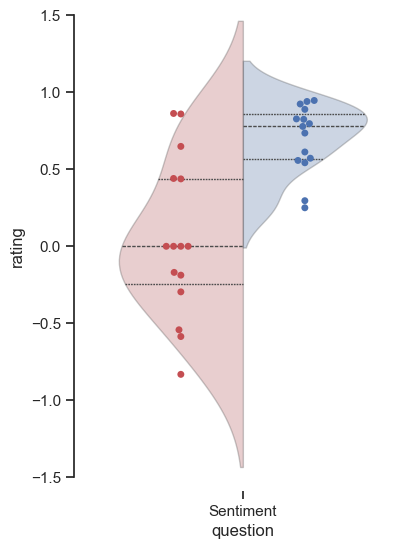

In [44]:
plt.figure(figsize = (4,6))
ax = sns.violinplot(data=df_sentiment, x="question", y="rating", hue="type", 
               split=True, inner="quart", linewidth=1,
               palette={"Human": "r", "AI": "b"});
for violin, alpha in zip(ax.collections[::], [0.3,0.3, 0.3, 0.3]): violin.set_alpha(alpha)

sns.swarmplot(data=df_sentiment, x="question", y="rating",
              hue="type", dodge = True,
              palette={"Human": "r", "AI": "b"});

plt.legend([],[], frameon=False)
plt.ylim(-1.5,1.5);
sns.despine(offset= 10, trim=True);


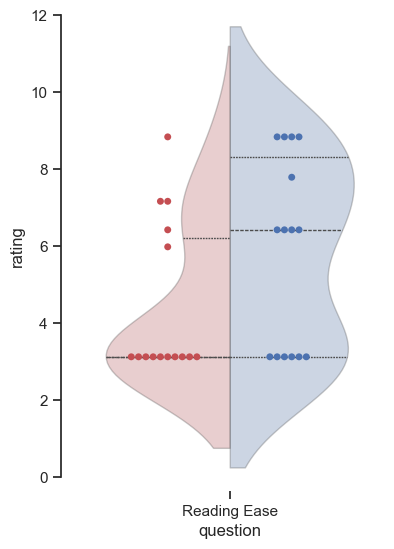

In [45]:
plt.figure(figsize = (4,6))
ax = sns.violinplot(data=df_ease, x="question", y="rating", hue="type", 
               split=True, inner="quart", linewidth=1,
               palette={"Human": "r", "AI": "b"});

for violin, alpha in zip(ax.collections[::], [0.3,0.3, 0.3, 0.3]):
    violin.set_alpha(alpha)

sns.swarmplot(data=df_ease, x="question", y="rating", 
              hue="type", dodge = True, palette={"Human": "r", "AI": "b"});

plt.legend([],[], frameon=False)
plt.ylim(0,12);
sns.despine(offset= 10, trim=True);